In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cartopy.crs as ccrs
import cartopy.feature as cf
import netCDF4
import pandas as pd
import datetime
import pytz 
from tzwhere import tzwhere
import math
from suntime import Sun
import scipy as sci
from scipy import stats
from scipy.stats import norm
import seaborn as sns
import cdo
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

In [310]:
def get_data(len_data, NU_WU):  #len_data is the number of files i want to read in (e.g. 4 for 4h hourly data), NU_WU is a str and you can define if you want 'with urban' or 'no urban'
    ds_data = {}  
    for i in range(1, len_data + 1):
        filename = f'../det_data_all_2022/fc_DOM01_0{i:03d}_{NU_WU}_urban_grid.nc'
        try:
            ds_data[i] = xr.open_dataset(filename)
 #           print(f'Successfully opened {filename}')
        except FileNotFoundError:
            print(f'File not found: {filename}')
        except Exception as e:
            print(f'An error occurred while opening {filename}: {e}')
    
    return ds_data

def get_data_nights(len_data, NU_WU):  #len_data is the number of files i want to read in (e.g. 4 for 4h hourly data), NU_WU is a str and you can define if you want 'with urban' or 'no urban'
    ds_data = {}  
    for i in range(1, len_data + 1):
        filename = f'../det_data_nights_2022/fc_DOM01_0{i:03d}_{NU_WU}_urban_grid_nights.nc'
        try:
            ds_data[i] = xr.open_dataset(filename)
#            print(f'Successfully opened {filename}')
        except FileNotFoundError:
            print(f'File not found: {filename}')
        except Exception as e:
            print(f'An error occurred while opening {filename}: {e}')
    
    return ds_data

def get_data_days(len_data, NU_WU):  #len_data is the number of files i want to read in (e.g. 4 for 4h hourly data), NU_WU is a str and you can define if you want 'with urban' or 'no urban'
    ds_data = {}  
    for i in range(1, len_data + 1):
        filename = f'../det_data_day_2022/fc_DOM01_0{i:03d}_{NU_WU}_urban_grid_days.nc'
        try:
            ds_data[i] = xr.open_dataset(filename)
#            print(f'Successfully opened {filename}')
        except FileNotFoundError:
            print(f'File not found: {filename}')
        except Exception as e:
            print(f'An error occurred while opening {filename}: {e}')
    
    return ds_data

def get_variable_1d_WU(len_data, data, variable, height_level, hour): #data is the output of 'get_data', variable is e.g. 'T' (as str), height_level (mostly 1 for urban), hour is time in this case 0 because one file only has one timestep
    ds_data = {}
    for i in range(1, len_data+1):
        ds_data[i] = data[i][f'{variable}'].isel(time = hour, height_3 = height_level)
    
    return ds_data

def get_variable_1d_NU(len_data, data, variable, height_level, hour): #data is the output of 'get_data', variable is e.g. 'T' (as str), height_level (mostly 1 for urban), hour is time in this case 0 because one file only has one timestep
    ds_data = {}
    for i in range(1, len_data+1):
        ds_data[i] = data[i][f'{variable}'].isel(time = hour, height = height_level)
    
    return ds_data

In [164]:
#read in the ful deterministic files

data_WU_det = get_data(120, 'WU')
data_NU_det = get_data(120, 'NU') 

In [3]:
#read in the determinstic run files

data_WU_nights_det = get_data_nights(120, 'WU')
data_NU_nights_det = get_data_nights(120, 'NU')

In [4]:
data_WU_days_det = get_data_days(120, 'WU')
data_NU_days_det = get_data_days(120, 'NU')

In [10]:
T_2M_WU_nights_det = get_variable_1d_WU(120, data_WU_nights_det, 'T_2M', 0 , 0)
T_2M_NU_nights_det = get_variable_1d_NU(120, data_NU_nights_det, 'T_2M', 0 , 0)

In [311]:
T_2M_WU_days_det = get_variable_1d_WU(120, data_WU_days_det, 'T_2M', 0 , 0)
T_2M_NU_days_det = get_variable_1d_NU(120, data_NU_days_det, 'T_2M', 0 , 0)

In [55]:
T_2M_WU_nights_dim_hour_det = xr.concat(list(zip(*T_2M_WU_nights_det.items()))[1], dim = 'hour')
T_2M_NU_nights_dim_hour_det = xr.concat(list(zip(*T_2M_NU_nights_det.items()))[1], dim = 'hour')

## Topography Maps

In [268]:
mean_T_2M_NU_nights_det = []

for i in range(247):
    mean = T_2M_NU_nights_dim_hour_det.isel(cell=i).mean()
    mean_T_2M_NU_nights_det.append(mean)

In [267]:
mean_T_2M_WU_nights_det = []

for i in range(247):
    mean = T_2M_WU_nights_dim_hour_det.isel(cell=i).mean()
    mean_T_2M_WU_nights_det.append(mean)

In [270]:
diff_T_2M_nights_det = []

for i in range(247):
    diff = mean_T_2M_WU_nights_det[i] - mean_T_2M_NU_nights_det[i]
    diff_T_2M_nights_det.append(diff)

diff_T_2M_nights_det = np.array(diff_T_2M_nights_det)
lon = np.degrees(np.asarray(data_WU_det[1]['clon']))
lat = np.degrees(np.asarray(data_WU_det[1]['clat']))

# Create xarray dataset
data = xr.Dataset({'clon': ('points', lon),
                   'clat': ('points', lat),
                   'value': ('points', diff_T_2M_nights_det)})


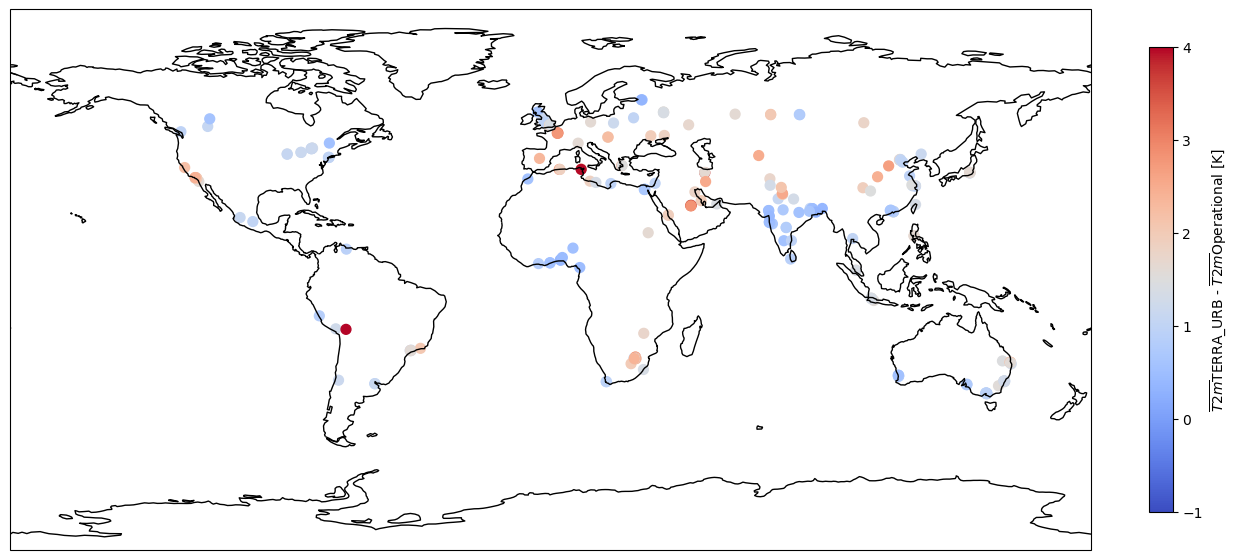

In [345]:
fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection=ccrs.PlateCarree())
sc = ax.scatter(data['clon'], data['clat'], c=data['value'], cmap='coolwarm',
                transform=ccrs.PlateCarree(), s=50, alpha=1)
cbar = plt.colorbar(sc, ax=ax, orientation='vertical', 
                    label='$\overline{T2m}$TERRA_URB - $\overline{T2m}$Operational [K]',
                    fraction=0.02)
sc.set_clim(-1, 4)
ax.coastlines()
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
plt.savefig('../plots_2024/world_map_mean_differences_2022.jpeg')